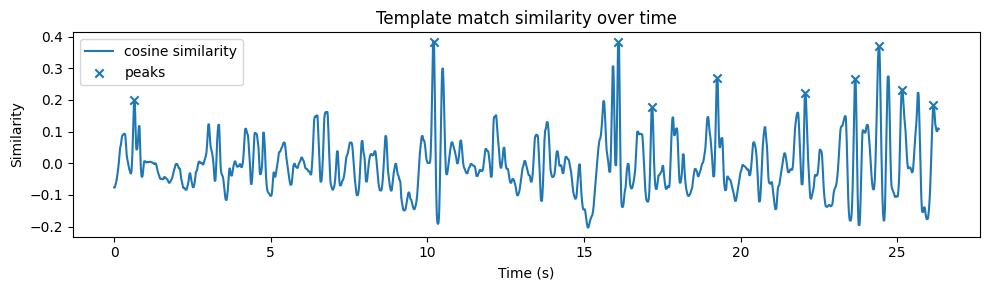

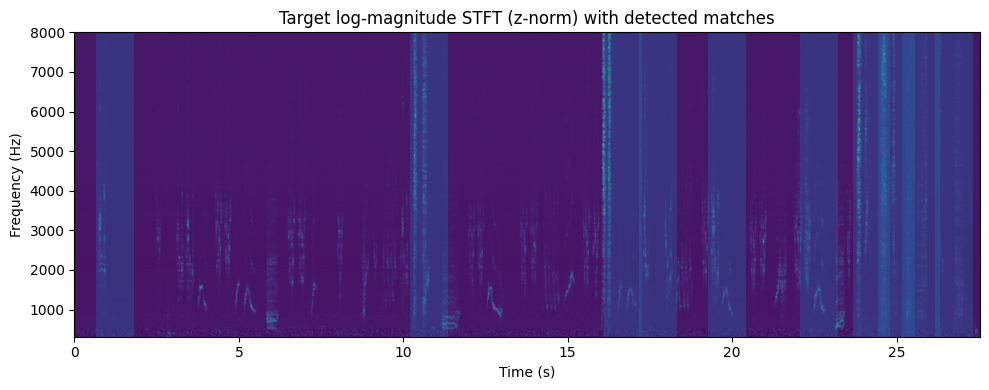

,start_s,end_s,similarity
0,10.20,11.35,0.3845
1,16.10,17.25,0.3823
2,24.42,25.57,0.3693
3,19.26,20.41,0.2698
4,23.66,24.81,0.2670
5,25.16,26.31,0.2330
6,22.07,23.22,0.2222
7,0.65,1.80,0.2000
8,26.16,27.31,0.1828
9,17.18,18.33,0.1773


In [4]:
import os, numpy as np, pandas as pd, soundfile as sf, matplotlib.pyplot as plt
from scipy.signal import stft, resample_poly, medfilt, find_peaks

# ---------- Parameters ----------
TEMPLATE_PATH = "../data/raw/blue_bird_repetoire/wolf_whistle.wav"
TARGET_PATH   = "../data/interim/interesting.flac"

SR = 16000           # resample rate
N_FFT = 1024
HOP = 160            # 10 ms
WINDOW = 'hann'
FMIN = 300           # optional band-pass by zeroing bins
FMAX = 8000
SMOOTH_WIN = 5
TOP_K = 10
PROMINENCE = 0.05
REL_HEIGHT = 0.0

def load_audio(path, target_sr):
    y, sr = sf.read(path, always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    if sr != target_sr:
        # rational resampling
        from math import gcd
        g = gcd(sr, target_sr)
        up, down = target_sr // g, sr // g
        y = resample_poly(y, up, down)
        sr = target_sr
    return y.astype(np.float32), sr

def stft_logmag(y, sr, n_fft, hop, window, fmin=None, fmax=None):
    f, t, Z = stft(y, fs=sr, nperseg=n_fft, noverlap=n_fft-hop, window=window, boundary=None, padded=False)
    mag = np.abs(Z) + 1e-10
    # Optional band-pass by frequency bin mask
    if fmin is not None or fmax is not None:
        mask = np.ones_like(f, dtype=bool)
        if fmin is not None:
            mask &= f >= fmin
        if fmax is not None:
            mask &= f <= fmax
        mag = mag[mask, :]
        f = f[mask]
    X = np.log1p(mag)  # log magnitude
    # Per-bin z-norm
    X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)
    return f, t, X  # X shape [F, T]

def sliding_cosine(template_feat, target_feat):
    F, Tq = template_feat.shape
    F2, T  = target_feat.shape
    assert F == F2 and T >= Tq, "Feature dims must match; target must be longer"
    tvec = template_feat.reshape(-1)
    tnorm = np.linalg.norm(tvec) + 1e-8
    # rolling windows along time
    # to save memory for long signals, chunk the loop
    N = T - Tq + 1
    sim = np.empty(N, dtype=np.float32)
    chunk = 20000  # adjust for memory/speed tradeoff
    for start in range(0, N, chunk):
        end = min(N, start + chunk)
        # Build [end-start, F*Tq] block
        block = np.empty((end-start, F*Tq), dtype=np.float32)
        for i, s in enumerate(range(start, end)):
            block[i] = target_feat[:, s:s+Tq].reshape(-1)
        norms = np.linalg.norm(block, axis=1) + 1e-8
        dots = block @ tvec
        sim[start:end] = dots / (norms * tnorm)
    return sim

def frames_to_time(frames, hop, sr):
    return (np.asarray(frames) * hop) / float(sr)

yq, _ = load_audio(TEMPLATE_PATH, SR)
y,  _ = load_audio(TARGET_PATH, SR)

# Features
fq, tq, Xq = stft_logmag(yq, SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)
f , t , X  = stft_logmag(y , SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)

if X.shape[1] < Xq.shape[1]:
    raise ValueError("Template is longer than target in frames. Provide a shorter template or longer target.")

# Similarity
sim = sliding_cosine(Xq, X)
sim_smooth = medfilt(sim, kernel_size=SMOOTH_WIN if SMOOTH_WIN%2==1 else SMOOTH_WIN+1)

# Peaks
template_dur_s = Xq.shape[1] * HOP / SR
min_distance_frames = max(1, int((Xq.shape[1]) * 0.5))
peaks, props = find_peaks(sim_smooth, prominence=PROMINENCE, distance=min_distance_frames, rel_height=REL_HEIGHT)
order = np.argsort(sim_smooth[peaks])[::-1]
peaks = peaks[order][:TOP_K]

starts_sec = frames_to_time(peaks, HOP, SR)
ends_sec   = starts_sec + template_dur_s
scores     = sim_smooth[peaks]

df = pd.DataFrame({
    "start_s": np.round(starts_sec, 3),
    "end_s":   np.round(ends_sec, 3),
    "similarity": np.round(scores, 4)
})

# Save CSV
# csv_path = "../data/processed/wolf_whistle_matches.csv"
# df.to_csv(csv_path, index=False)

# Plot 1: similarity
plt.figure(figsize=(10, 3))
t_sim = frames_to_time(np.arange(len(sim_smooth)), HOP, SR)
plt.plot(t_sim, sim_smooth, label="cosine similarity")
if len(peaks):
    plt.scatter(starts_sec, scores, marker="x", label="peaks")
plt.xlabel("Time (s)")
plt.ylabel("Similarity")
plt.title("Template match similarity over time")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: spectrogram with spans
plt.figure(figsize=(10, 4))
# ensure extent is a tuple[float, float, float, float] (xmin, xmax, ymin, ymax)
extent = (
    0.0,
    float(len(y) / SR),
    float(f[0]) if len(f) > 0 else 0.0,
    float(f[-1]) if len(f) > 0 else float(SR / 2),
)
plt.imshow(X, aspect='auto', origin='lower', extent=extent)
for s, e in zip(starts_sec, ends_sec):
    plt.axvspan(s, e, alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Target log-magnitude STFT (z-norm) with detected matches")
plt.tight_layout()
plt.show()

df


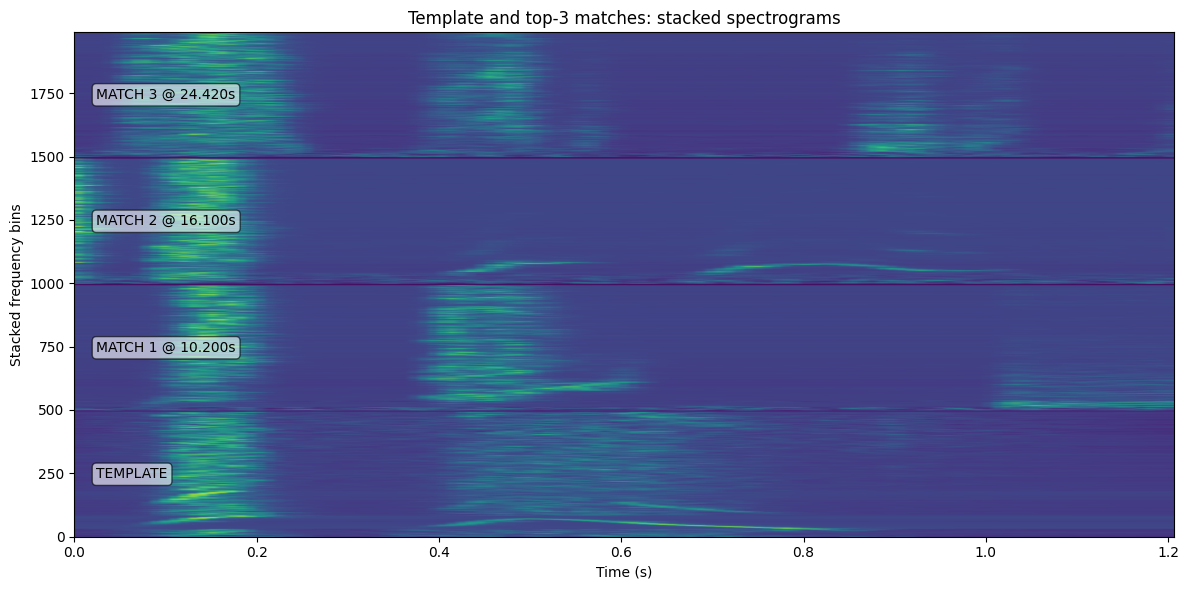

In [5]:
import os, numpy as np, soundfile as sf, matplotlib.pyplot as plt, pandas as pd
from scipy.signal import stft, resample_poly, find_peaks, medfilt

# ---------- Parameters ----------
TEMPLATE_PATH = "../data/raw/blue_bird_repetoire/wolf_whistle.wav"
TARGET_PATH   = "../data/interim/interesting.flac"
CSV_PATH      = "../data/processed/wolf_whistle_matches.csv"

SR = 16000
N_FFT = 1024
HOP = 160
WINDOW = 'hann'
FMIN = 300
FMAX = 8000

# Fallback peak-pick params if CSV absent
SMOOTH_WIN = 5
PROMINENCE = 0.05

def load_audio(path, target_sr):
    y, sr = sf.read(path, always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    if sr != target_sr:
        from math import gcd
        g = gcd(sr, target_sr)
        up, down = target_sr // g, sr // g
        y = resample_poly(y, up, down)
        sr = target_sr
    return y.astype(np.float32), sr

def stft_logmag(y, sr, n_fft, hop, window, fmin=None, fmax=None):
    f, t, Z = stft(y, fs=sr, nperseg=n_fft, noverlap=n_fft-hop, window=window, boundary=None, padded=False)
    mag = np.abs(Z) + 1e-10
    if fmin is not None or fmax is not None:
        mask = np.ones_like(f, dtype=bool)
        if fmin is not None:
            mask &= f >= fmin
        if fmax is not None:
            mask &= f <= fmax
        mag = mag[mask, :]
        f = f[mask]
    X = np.log1p(mag)
    X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)
    return f, t, X  # [F, T]

def compute_similarity_and_peaks(yq, y):
    # Build features for both, then sliding-window cosine similarity to get peaks
    fq, tq, Xq = stft_logmag(yq, SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)
    f , t , X  = stft_logmag(y , SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)
    if X.shape[1] < Xq.shape[1]:
        raise ValueError("Template longer than target in frames.")
    # Sliding similarity (simple, memory-safe)
    F, Tq = Xq.shape
    N = X.shape[1] - Tq + 1
    tvec = Xq.reshape(-1)
    tnorm = np.linalg.norm(tvec) + 1e-8
    sim = np.empty(N, dtype=np.float32)
    chunk = 20000
    for start in range(0, N, chunk):
        end = min(N, start+chunk)
        block = np.empty((end-start, F*Tq), dtype=np.float32)
        for i, s in enumerate(range(start, end)):
            block[i] = X[:, s:s+Tq].reshape(-1)
        norms = np.linalg.norm(block, axis=1) + 1e-8
        dots = block @ tvec
        sim[start:end] = dots / (norms * tnorm)
    sim_s = medfilt(sim, kernel_size=SMOOTH_WIN if SMOOTH_WIN%2==1 else SMOOTH_WIN+1)
    # Peaks
    min_distance_frames = max(1, int(Tq * 0.5))
    peaks, props = find_peaks(sim_s, prominence=PROMINENCE, distance=min_distance_frames)
    # Sort top-3
    if len(peaks) == 0:
        return Xq, [], sim_s
    order = np.argsort(sim_s[peaks])[::-1]
    peaks = peaks[order][:3]
    return Xq, peaks, sim_s

# Load audio
if not (os.path.exists(TEMPLATE_PATH) and os.path.exists(TARGET_PATH)):
    raise FileNotFoundError("Audio files not found at expected paths.")

yq, _ = load_audio(TEMPLATE_PATH, SR)
y , _ = load_audio(TARGET_PATH, SR)

# Template spectrogram
fq, tq, Xq = stft_logmag(yq, SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)
Tq = Xq.shape[1]
template_duration = len(yq) / SR

# Decide starts of top-3 matches
if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    df = df.sort_values("similarity", ascending=False).head(3)
    starts_sec = df["start_s"].values.tolist()
else:
    # Fallback: compute peaks now
    Xq2, peak_frames, sim_s = compute_similarity_and_peaks(yq, y)
    if len(peak_frames) == 0:
        # No peaks found; still produce a stack of just the template
        starts_sec = []
    else:
        starts_sec = [(pf * HOP) / SR for pf in peak_frames]

# Extract segments and compute spectrograms
segments = [("TEMPLATE", Xq, template_duration)]
for i, s in enumerate(starts_sec):
    start_samp = int(round(s * SR))
    end_samp   = start_samp + len(yq)
    if end_samp > len(y):
        end_samp = len(y)
        start_samp = max(0, end_samp - len(yq))
    seg = y[start_samp:end_samp]
    f, t, Xseg = stft_logmag(seg, SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)
    # Trim/pad time dimension to match template frames
    if Xseg.shape[1] > Tq:
        Xseg = Xseg[:, :Tq]
    elif Xseg.shape[1] < Tq:
        pad = np.full((Xseg.shape[0], Tq - Xseg.shape[1]), Xseg.min(), dtype=Xseg.dtype)
        Xseg = np.hstack([Xseg, pad])
    segments.append((f"MATCH {i+1} @ {s:.3f}s", Xseg, len(seg)/SR))

# Build vertical stack
if len(segments) == 1:
    # Only template available
    labels = [segments[0][0]]
    stack = segments[0][1]
else:
    labels = []
    arrays = []
    spacer_rows = 6
    for label, Xarr, dur in segments[:4]:  # template + top 3
        labels.append(label)
        arrays.append(Xarr)
        arrays.append(np.full((spacer_rows, Xarr.shape[1]), Xarr.min(), dtype=Xarr.dtype))
    arrays = arrays[:-1]  # drop last spacer
    stack = np.vstack(arrays)

# Render single image
plt.figure(figsize=(12, 6))
extent = [0, template_duration, 0, stack.shape[0]]  # x in seconds
plt.imshow(stack, aspect='auto', origin='lower', extent=extent)
# Add label text at mid of each block
cursor = 0
for label, Xarr, dur in segments[:4]:
    y_mid = cursor + Xarr.shape[0] / 2.0
    plt.text(0.02*template_duration, y_mid, label, va='center', ha='left', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.6, boxstyle='round'))
    cursor += Xarr.shape[0] + (spacer_rows if len(segments)>1 else 0)
plt.xlabel("Time (s)")
plt.ylabel("Stacked frequency bins")
plt.title("Template and top-3 matches: stacked spectrograms")
plt.tight_layout()
plt.show()

In [6]:
import os, numpy as np, pandas as pd, soundfile as sf
from scipy.signal import resample_poly, stft, medfilt, find_peaks
from IPython.display import Audio, display

# ------------ Parameters ------------
TEMPLATE_PATH = "../data/raw/blue_bird_repetoire/wolf_whistle.wav"
TARGET_PATH   = "../data/interim/interesting.flac"
CSV_PATH      = "../data/processed/wolf_whistle_matches.csv"

SR = 16000
N_MATCHES = 5
CONTEXT_SEC = 0.0   # set >0 to add equal pre/post context around the snippet

# Reuse analysis params for fallback peak-picking
N_FFT = 1024
HOP = 160
WINDOW = 'hann'
FMIN = 300
FMAX = 8000
SMOOTH_WIN = 5
PROMINENCE = 0.05

def load_audio(path, target_sr):
    y, sr = sf.read(path, always_2d=False)
    if y.ndim == 2:
        y = y.mean(axis=1)
    if sr != target_sr:
        from math import gcd
        g = gcd(sr, target_sr)
        up, down = target_sr // g, sr // g
        y = resample_poly(y, up, down)
        sr = target_sr
    return y.astype(np.float32), sr

def stft_logmag(y, sr, n_fft, hop, window, fmin=None, fmax=None):
    from scipy.signal import stft as _stft
    f, t, Z = _stft(y, fs=sr, nperseg=n_fft, noverlap=n_fft-hop, window=window, boundary=None, padded=False)
    mag = np.abs(Z) + 1e-10
    if fmin is not None or fmax is not None:
        mask = np.ones_like(f, dtype=bool)
        if fmin is not None:
            mask &= f >= fmin
        if fmax is not None:
            mask &= f <= fmax
        mag = mag[mask, :]
        f = f[mask]
    X = np.log1p(mag)
    X = (X - X.mean(axis=1, keepdims=True)) / (X.std(axis=1, keepdims=True) + 1e-8)
    return f, t, X  # [F, T]

def compute_similarity_and_peaks(yq, y):
    # Build features for both, then sliding-window cosine similarity to get peaks
    fq, tq, Xq = stft_logmag(yq, SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)
    f , t , X  = stft_logmag(y , SR, N_FFT, HOP, WINDOW, fmin=FMIN, fmax=FMAX)
    if X.shape[1] < Xq.shape[1]:
        raise ValueError("Template longer than target in frames.")
    # Sliding similarity
    F, Tq = Xq.shape
    N = X.shape[1] - Tq + 1
    tvec = Xq.reshape(-1)
    tnorm = np.linalg.norm(tvec) + 1e-8
    sim = np.empty(N, dtype=np.float32)
    chunk = 20000
    for start in range(0, N, chunk):
        end = min(N, start+chunk)
        block = np.empty((end-start, F*Tq), dtype=np.float32)
        for i, s in enumerate(range(start, end)):
            block[i] = X[:, s:s+Tq].reshape(-1)
        norms = np.linalg.norm(block, axis=1) + 1e-8
        dots = block @ tvec
        sim[start:end] = dots / (norms * tnorm)
    sim_s = medfilt(sim, kernel_size=SMOOTH_WIN if SMOOTH_WIN%2==1 else SMOOTH_WIN+1)
    # Peaks
    min_distance_frames = max(1, int(Tq * 0.5))
    peaks, props = find_peaks(sim_s, prominence=PROMINENCE, distance=min_distance_frames)
    order = np.argsort(sim_s[peaks])[::-1]
    peaks = peaks[order]
    # to seconds
    starts_sec = (peaks * HOP) / float(SR)
    scores = sim_s[peaks]
    ends_sec = starts_sec + (len(yq) / float(SR))
    df = pd.DataFrame({"start_s": starts_sec, "end_s": ends_sec, "similarity": scores})
    return df

template, _ = load_audio(TEMPLATE_PATH, SR)
target, _   = load_audio(TARGET_PATH, SR)
template_len = len(template)

# Get matches
if os.path.exists(CSV_PATH):
    matches = pd.read_csv(CSV_PATH).sort_values("similarity", ascending=False)
else:
    matches = compute_similarity_and_peaks(template, target).sort_values("similarity", ascending=False)

matches = matches.head(N_MATCHES).reset_index(drop=True)

# Prepare outputs directory and export wavs
out_paths = []
rows = []
pad = int(CONTEXT_SEC * SR)
for i, row in matches.iterrows():
    start_s = float(row["start_s"])
    s = int(round(start_s * SR)) - pad
    e = s + template_len + 2*pad
    s = max(0, s)
    e = min(len(target), e)
    clip = target[s:e]
    out_path = f"../data/processed/match_{i+1}.wav"
    sf.write(out_path, clip, SR)
    out_paths.append(out_path)
    rows.append({
        "match_rank": i+1,
        "start_s": round(start_s, 3),
        "end_s": round(start_s + template_len/SR, 3),
        "similarity": round(float(row["similarity"]), 4),
        "file": out_path
    })

# Display template and matches as audio widgets
print("Template:")
display(Audio(template, rate=SR))

for i, (row, p) in enumerate(zip(rows, out_paths), start=1):
    print(f"Match {i}  |  start={row['start_s']}s  end={row['end_s']}s  sim={row['similarity']}")
    display(Audio(filename=p))

# Show table and make it available as an interactive grid
df_out = pd.DataFrame(rows)
df_out

Template:


Match 1  |  start=10.2s  end=11.407s  sim=0.3845


Match 2  |  start=16.1s  end=17.307s  sim=0.3823


Match 3  |  start=24.42s  end=25.627s  sim=0.3693


Match 4  |  start=19.26s  end=20.467s  sim=0.2698


Match 5  |  start=23.66s  end=24.867s  sim=0.267


,match_rank,start_s,end_s,similarity,file
0,1,10.20,11.407,0.3845,../data/processed/match_1.wav
1,2,16.10,17.307,0.3823,../data/processed/match_2.wav
2,3,24.42,25.627,0.3693,../data/processed/match_3.wav
3,4,19.26,20.467,0.2698,../data/processed/match_4.wav
4,5,23.66,24.867,0.2670,../data/processed/match_5.wav
